# Roest Lab Jupyter Notebook for Exploratory Data Analysis
This notebook is configured to the `roest-lab` virtual environment. Please ensure you have the `roest-lab` kernel activated when using this notebook.

## Required PyPI packages
- `numpy`
- `pyopenms`

## Auxiliary PyPI packages for data analysis
- `matplotlib`

In [1]:
print("Welcome to the Roest Lab Exploratory MS Jupyter Notebook!")

Welcome to the Roest Lab Exploratory MS Jupyter Notebook!


In [8]:
# Set common directories
import os

BASE_DIR = os.path.abspath(os.getcwd())
DATA_DIR = os.path.join(BASE_DIR, 'data')

In [9]:
# From pyOpenMS tutorial page - https://pyopenms.readthedocs.io/en/latest/first_steps.html
from pyopenms import MSExperiment, MzMLFile

exp = MSExperiment()
MzMLFile().store(os.path.join(DATA_DIR, 'testfile.mzML'), exp)


In [10]:
# Get help with Python objects in pyOpenMS
# help(MzMLFile)
# help(MSExperiment)

## File reading

In [11]:
import os
from urllib.request import urlretrieve

# Download small mzML file
github_content = "https://raw.githubusercontent.com/OpenMS/pyopenms-extra/master"
tiny_mzml_filepath = os.path.join(DATA_DIR, "tiny.mzML")
urlretrieve(f"{github_content}/src/data/tiny.mzML", tiny_mzml_filepath)

('/Users/irahorecka/Desktop/Harddrive_Desktop/PhD/University of Toronto/Rotations/Rost Lab/roest-ms/data/tiny.mzML',
 <http.client.HTTPMessage at 0x7f9f90d9c490>)

In [12]:
from pyopenms import MSExperiment, MzMLFile

exp = MSExperiment()
# Load file
MzMLFile().load(tiny_mzml_filepath, exp)

In [13]:
# tiny_mzml_filepath is loaded onto exp by reference

# View help of exp object
# help(exp)

# We can get information about spectra and chromatograms using the following methods
print("exp.getNrSpectra() -->", exp.getNrSpectra())
print("exp.getNrChromatograms() -->", exp.getNrChromatograms())

exp.getNrSpectra() --> 4
exp.getNrChromatograms() --> 2


In [14]:
# Iterate through spectra
for spectra in exp:
    print("MS Level:", spectra.getMSLevel())

MS Level: 1
MS Level: 2
MS Level: 1
MS Level: 1


In [15]:
# Use index to get spectrum
print("MS Level:", exp[1].getMSLevel())

MS Level: 2


In [16]:
# Obtain raw peaks
spec = exp[1]
mz, intensity = spec.get_peaks()
print(list(zip(mz, intensity)))
print(sum(intensity))

[(0.0, 20.0), (2.0, 18.0), (4.0, 16.0), (6.0, 14.0), (8.0, 12.0), (10.0, 10.0), (12.0, 8.0), (14.0, 6.0), (16.0, 4.0), (18.0, 2.0)]
110.0


## Total ion current calculation
Here, we will apply what we have learned to calculate the total ion current (TIC). The TIC represents the summed intensity across the entire range of masses being detected at every point in the analysis. Basically, we calculate the total ion current of the whole experiment.

In [17]:
# Define a function that calculates TIC for a given ms level

def calcTIC(exp, mslevel):
    tic = 0
    # Iter through all spectra of the experiment
    for spec in exp:
    # Only calc TIC for matching MS1 spectra
        if spec.getMSLevel() == mslevel:
            mz, i = spec.get_peaks()
            tic += sum(i)
    return tic

In [18]:
# Now let's use our function to calculate the TIC
print(calcTIC(exp, 1))
# A list comprehension version of the calcTIC function above
print(sum([sum(s.get_peaks()[1]) for s in exp if s.getMSLevel() == 1]))
print(calcTIC(exp, 2))

240.0
240.0
110.0


## TIC chromatogram
The total ion current is visualized over the retention time, to allow for the inspection of areas with general high intensity (usually multiple analytes were measured there). This can help the experimentalist to optimize the chromatography for a better seperation in a specific area.

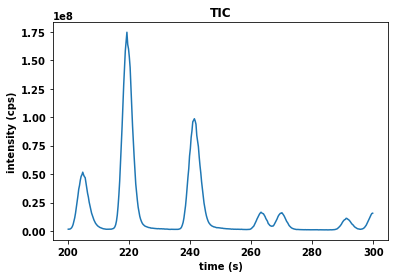

In [20]:
# Let's use matplotlib to visualize our TIC chromatogram
import matplotlib.pyplot as plt
from urllib.request import urlretrieve 

# retrieve MS data
gh = "https://raw.githubusercontent.com/OpenMS/pyopenms-extra/master"
output_ms_data = os.path.join(DATA_DIR, "ms_data.mzML")
urlretrieve (gh + "/src/data/FeatureFinderMetaboIdent_1_input.mzML", output_ms_data)

# load MS data into MSExperiment()
exp = MSExperiment()
MzMLFile().load(output_ms_data, exp)

# choose one of the following three methods to access the TIC data
# 1) recalculate TIC data with the calculateTIC() function
tic = exp.calculateTIC()
retention_times, intensities = tic.get_peaks()

# 2) get TIC data using list comprehensions
retention_times = [spec.getRT() for spec in exp]
intensities = [sum(spec.get_peaks()[1]) for spec in exp if spec.getMSLevel() == 1]

# 3) get TIC data looping over spectra in MSExperiment()
retention_times = []
intensities = []
for spec in exp:
    if spec.getMSLevel() == 1:
        retention_times.append(spec.getRT())
        intensities.append(sum(spec.get_peaks()[1]))

# plot retention times and intensities and add labels
plt.plot(retention_times, intensities)

plt.title('TIC')
plt.xlabel('time (s)')
plt.ylabel('intensity (cps)')

plt.show()